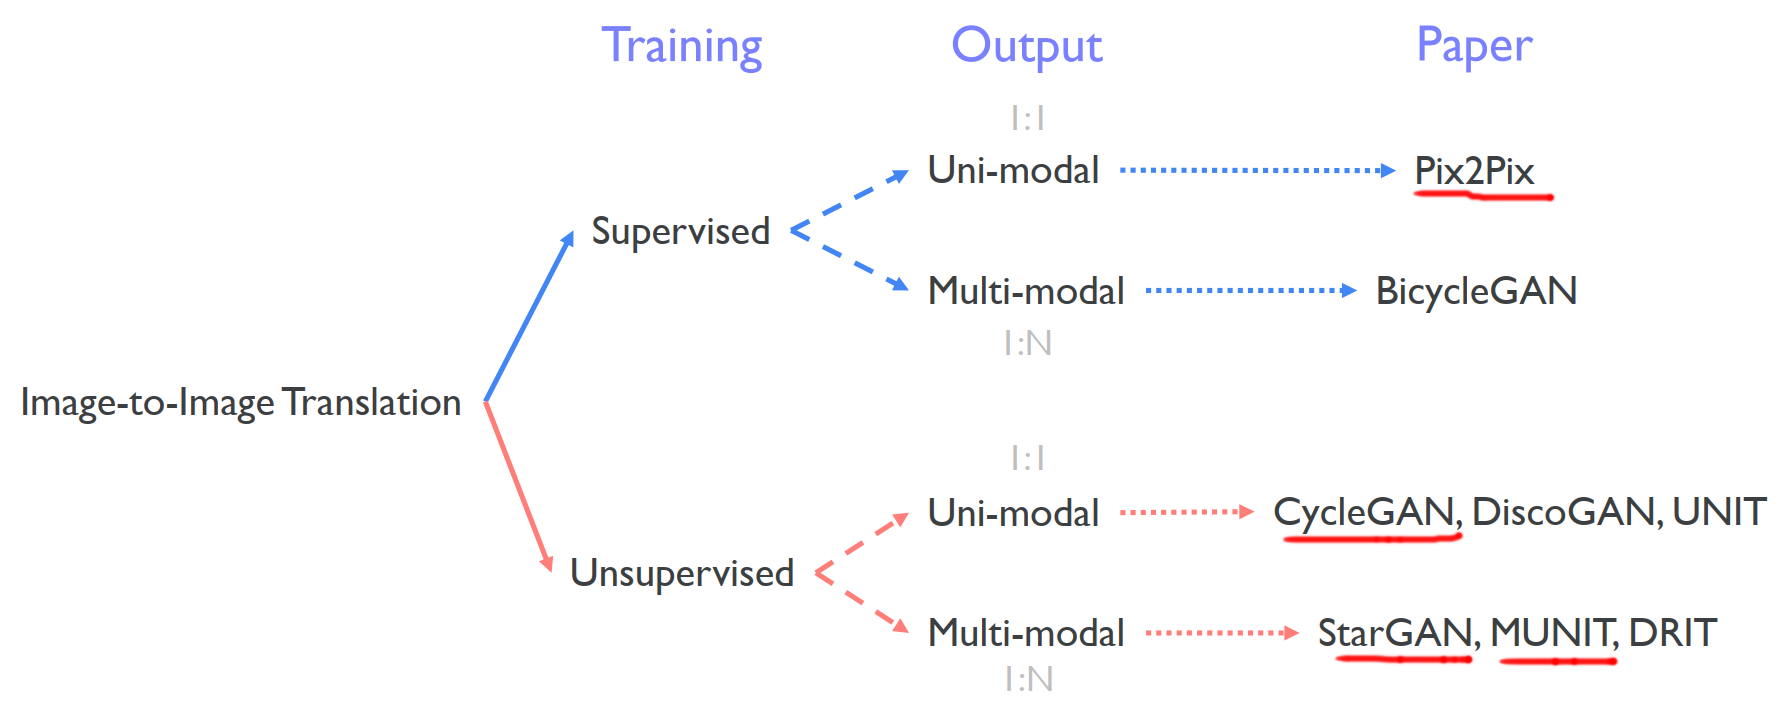

# CycleGAN model
* CycleGAN thuộc bài toán **unsupervised** uni-modal image to image translation
* Ví dụ với bài toán chuyển ngựa thường thành ngựa vằn (horse2zebra) hoặc ngược lại
* Do bài toán là **unsupervised**: 
    * Dataset chỉ có 2 tập ngựa vằn và ngựa thường thay vì từng paired (input, output) như Pix2Pix
    * Nếu như ở bài toán Pix2Pix, khi Generator sinh ra ảnh mình có thể dùng L1 loss hay GAN loss để train
    * Còn ở CycleGAN ta phải dựng thêm decoder để tạo loss function để train:
        * Dataset A là ảnh ngựa vằn, dataset B là ảnh ngựa thường
        * Mạng sẽ có 2 Generator: $G_{ab}$ chuyển từ ngựa vằn sang ngựa thường và $G_{ba}$ chuyển từ ngựa thường sang ngựa vằn
        * Mạng cx có 2 Discriminator $D_a$ để phân biệt ảnh ngựa vằn trong dataset A và ảnh do $G_{ba}$ sinh ra và $D_b$ để phân biệt ảnh ngựa thường trong dataset B và ảnh do $G_{ab}$ sinh ra
        
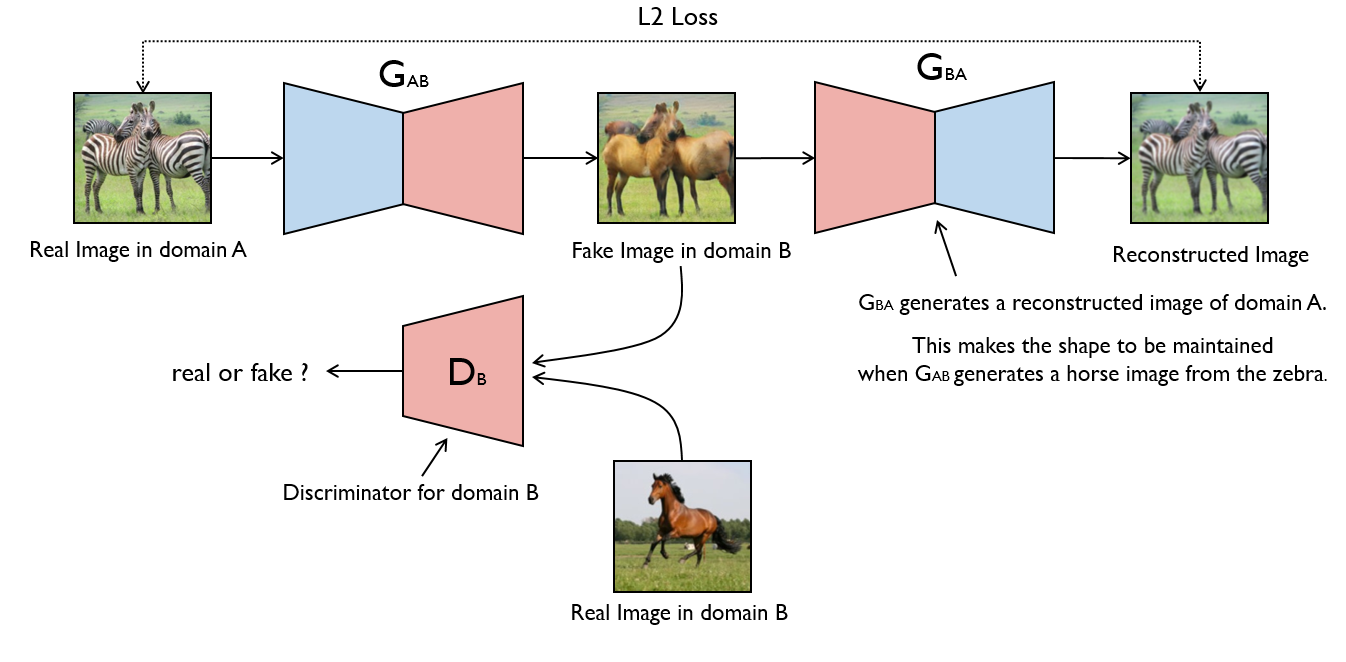
* Ta mong muốn ảnh đi qua $G_{ab}$ sau đó output qua $G_{ba}$ sẽ thành ảnh ban đầu hay $G_{ba}(G_{ab}(a))=a$
* Ta cũng sẽ có L2 loss để khôi phục ảnh ban đầu qua 2 Generator và thêm 2 GAN loss để học cho các ảnh sinh ra giống vs các ảnh trong dataset A và dataset B

# 1. Generator
* Generator có input là ảnh của 1 domain, output là ảnh của domain còn lại

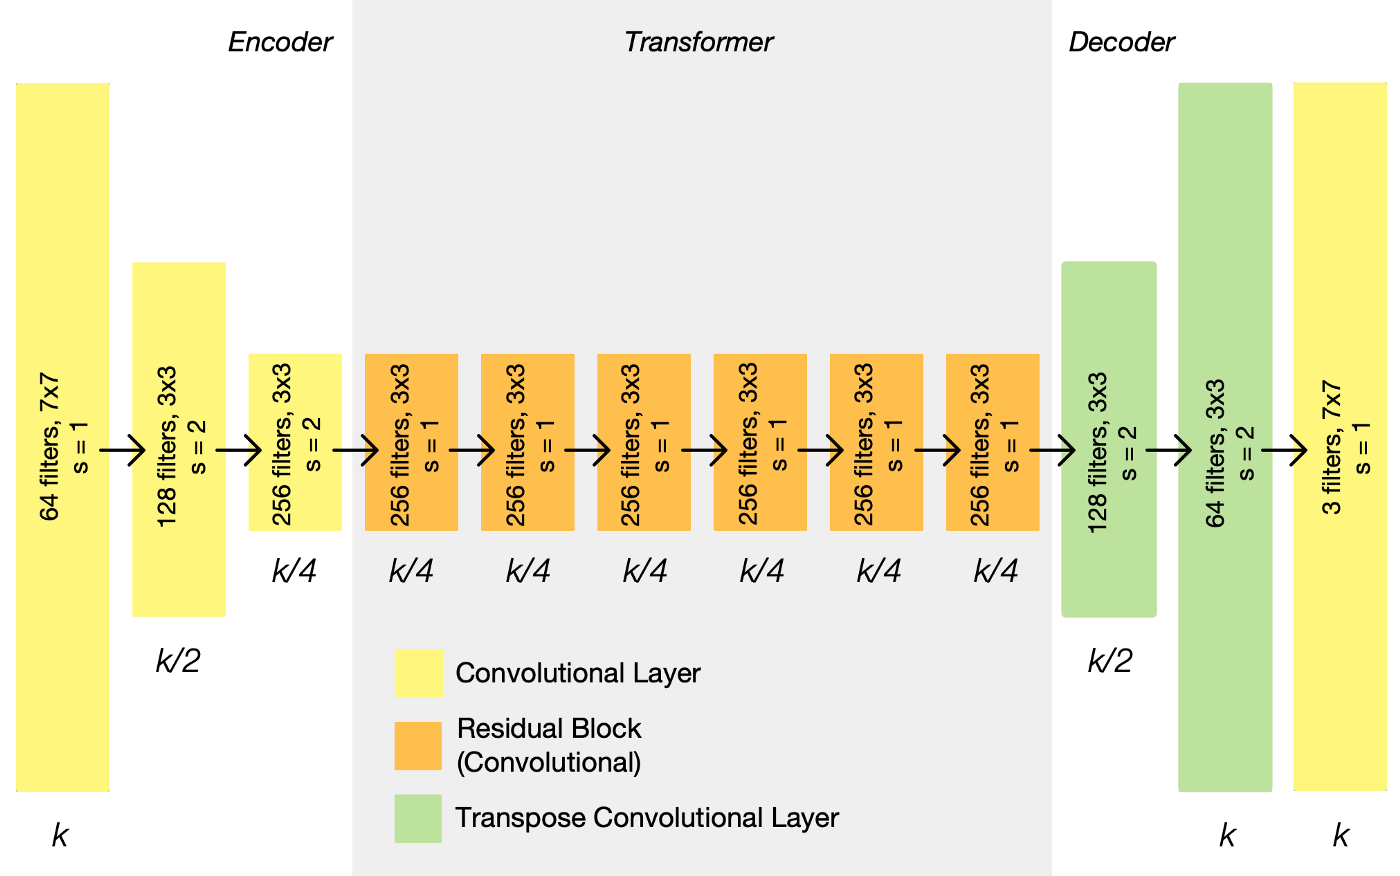
* Mạng dùng convolution layer với stride = 2 để thay pooling layer, mà ko có fully connected layer nên có thể nhận input ảnh kích thước tùy ý

# 2. Discriminator
* Discriminator dùng để phân biệt ảnh sinh ra bởi Generator hay ảnh thật trong dataset và vẫn sử dụng **PatchGAN** như Pix2Pix

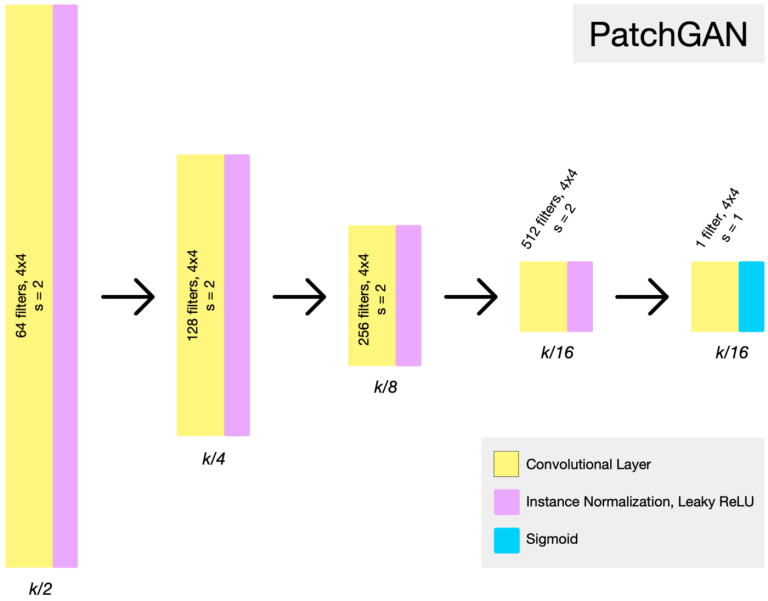

# 3. Loss function
* GAN loss:
> $
\begin{equation}
    \begin{split}
        \large{\displaystyle \mathcal{L}_{GAN(A2B)}}
        & \large{\displaystyle=\mathbb{E}_{b\in p_{data}(b)}[\log D_b(b)]+\mathbb{E}_{a\in p_{data}(a)}[\log(1-D_b(G_{ab}(a))]} \\
        \large{\displaystyle \mathcal{L}_{GAN(B2A)}}
        & \large{\displaystyle=\mathbb{E}_{a\in p_{data}(a)}[\log D_a(a)]+\mathbb{E}_{b\in p_{data}(b)}[\log(1-D_a(G_{ba}(b))]}
    \end{split}
\end{equation}
$
* Cycle-consistancy loss (L2 loss):
> $\large{\displaystyle\mathcal{L}_{cyc}=\mathbb{E}_{a\in p_{data}(a)}[\|G_{ba}(G_{ab}(a))-a\|_2]+\mathbb{E}_{b\in p_{data}(b)}[\|G_{ab}(G_{ba}(b))-b\|_2]}$
* Full loss:
    > $\large{\displaystyle\mathcal{L}=\mathcal{L}_{GAN(A2B)}+\mathcal{L}_{GAN(B2A)}+\lambda\mathcal{L}_{cyc}}\quad$ Trong đó:

    > $\lambda$ là hyper-parameter, thường chọn bằng 10
* Bản thân GAN loss có thể mapping phân phối giữa A và B, nhưng để mapping được như vậy thì cần rất nhiều ảnh nên L2 loss được thêm vào để model tạo ra ảnh thật hơn

In [1]:
# ! git clone https://www.github.com/keras-team/keras-contrib.git
# %cd keras-contrib
# ! python setup.py install

In [2]:
! pip install -q -U tensorflow-addons

In [28]:
!conda install pydot
!conda install pydotplus

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



In [42]:
import pydot_ng as pydot
import pydotplus, graphviz
import numpy as np
import matplotlib.pyplot as plt
import os, math, random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.initializers import RandomNormal
from tensorflow_addons.layers import InstanceNormalization
from tqdm.notebook import tqdm
from tensorflow.keras.utils import plot_model

In [2]:
def load_imgs(path, size = (256, 256)):
    data_list = []
    
    for filename in os.listdir(path):
        pixels = load_img(path + filename, target_size = size)
        pixels = img_to_array(pixels)
        data_list.append(pixels)
    return np.asarray(data_list)

In [5]:
path = '.\\Cycle_dataset\\horse2zebra\\horse2zebra\\'
dataA1 = load_imgs(path + 'trainA\\')
dataA2 = load_imgs(path + 'testA\\')
dataB1 = load_imgs(path + 'trainB\\')
dataB2 = load_imgs(path + 'testB\\')

dataA = np.concatenate((dataA1, dataA2), axis = 0)
dataB = np.concatenate((dataB1, dataB2), axis = 0)
print(dataA.shape)
print(dataB.shape)

filename = 'horse2zebra_256.npz'
np.savez_compressed(filename, dataA, dataB)
print('Saved:', filename)

(1187, 256, 256, 3)
(1474, 256, 256, 3)
Saved: horse2zebra_256.npz


Loaded: (1187, 256, 256, 3) (1474, 256, 256, 3)


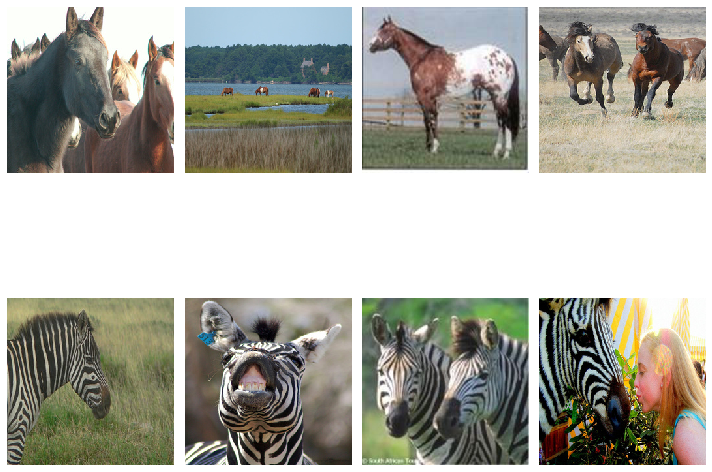

In [3]:
dataset = np.load('horse2zebra_256.npz')
dataA, dataB = dataset['arr_0'], dataset['arr_1']
print('Loaded:', dataA.shape, dataB.shape)

def plot_imgs(n_samples = 4):
    fig, axes = plt.subplots(2, n_samples, figsize = (10, 10))
    for i in range(n_samples):
        axes[0, i].imshow(dataA[i].astype('uint8'), interpolation = 'nearest')
        axes[0, i].axis('off')
        
    for i in range(n_samples):
        axes[1, i].imshow(dataB[i].astype('uint8'), interpolation = 'nearest')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

plot_imgs()

In [4]:
def build_discriminator(img_shape):
    init = RandomNormal(stddev = 0.02)
    
    in_img = Input(shape = img_shape)
    # C64
    d = Conv2D(64, kernel_size = (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = init)(in_img)
    d = LeakyReLU(alpha = 0.2)(d)
    # C128
    d = Conv2D(128, kernel_size = (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = init)(d)
    d = InstanceNormalization(axis = -1)(d)
    d = LeakyReLU(alpha = 0.2)(d)
    # C256
    d = Conv2D(256, kernel_size = (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = init)(d)
    d = InstanceNormalization(axis = -1)(d)
    d = LeakyReLU(alpha = 0.2)(d)
    # C512
    d = Conv2D(512, kernel_size = (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = init)(d)
    d = InstanceNormalization(axis = -1)(d)
    d = LeakyReLU(alpha = 0.2)(d)
    # Second last output
    d = Conv2D(512, kernel_size = (4, 4), padding = 'same', kernel_initializer = init)(d)
    d = InstanceNormalization(axis = -1)(d)
    d = LeakyReLU(alpha = 0.2)(d)
    # Patch output
    patch_out = Conv2D(1, kernel_size = (4, 4), padding = 'same', kernel_initializer = init)(d)
    
    model = Model(inputs = in_img, outputs = patch_out)
    adam = Adam(learning_rate = 2e-4, beta_1 = 0.5)
    model.compile(loss = 'mse', optimizer = adam, loss_weights = [0.5])
    return model

In [6]:
def resnet_block(n_filters, input_layer):
    init = RandomNormal(stddev = 0.02)
    
    # First convolutional layer
    g = Conv2D(n_filters, kernel_size = (3, 3), padding = 'same', kernel_initializer = init)(input_layer)
    g = InstanceNormalization(axis = -1)(g)
    g = Activation('relu')(g)
    # Second convolutional layer
    g = Conv2D(n_filters, kernel_size = (3, 3), padding = 'same', kernel_initializer = init)(g)
    g = InstanceNormalization(axis = -1)(g)
    
    g = Concatenate()([g, input_layer])
    return g

def build_generator(img_shape, n_resnet = 9):
    init = RandomNormal(stddev = 0.02)
    
    in_img = Input(shape = img_shape)
    # C7s1-64
    g = Conv2D(64, kernel_size = (7, 7), padding = 'same', kernel_initializer = init)(in_img)
    g = InstanceNormalization(axis = -1)(g)
    g = Activation('relu')(g)
    # D128
    g = Conv2D(128, kernel_size = (3, 3), strides = (2, 2), padding = 'same', kernel_initializer = init)(g)
    g = InstanceNormalization(axis = -1)(g)
    g = Activation('relu')(g)
    # D256
    g = Conv2D(256, kernel_size = (3, 3), strides = (2, 2), padding = 'same', kernel_initializer = init)(g)
    g = InstanceNormalization(axis = -1)(g)
    g = Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    # U128
    g = Conv2DTranspose(128, kernel_size = (3, 3), strides = (2, 2), padding = 'same', kernel_initializer = init)(g)
    g = InstanceNormalization(axis = -1)(g)
    g = Activation('relu')(g)
    # U64
    g = Conv2DTranspose(64, kernel_size = (3, 3), strides = (2, 2), padding = 'same', kernel_initializer = init)(g)
    g = InstanceNormalization(axis = -1)(g)
    g = Activation('relu')(g)
    # C7s1-3
    g = Conv2D(3, kernel_size = (7, 7), padding = 'same', kernel_initializer = init)(g)
    g = InstanceNormalization(axis = -1)(g)
    out_img = Activation('tanh')(g)
    
    model = Model(inputs = in_img, outputs = out_img)
    return model

In [63]:
# Composite model to updating Generators by adversarial and cycle loss
def build_composite_model(g_model_1, d_model, g_model_2, img_shape):
    # Ensure the model updating is trainable
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    # Discriminator element
    input_gen = Input(shape = img_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    
    # Identity element
    input_ide = Input(shape = img_shape)
    output_ide = g_model_1(input_ide)
    
    # Forward cycle
    output_f = g_model_2(gen1_out)
    
    # Backward cycle
    gen2_out = g_model_2(input_ide)
    output_b = g_model_1(gen2_out)
    
    model = Model(inputs = [input_gen, input_ide], outputs = [output_d, output_ide, output_f, output_b])
    adam = Adam(learning_rate = 2e-4, beta_1 = 0.5)
    model.compile(optimizer = adam, loss = ['mse', 'mae', 'mae', 'mae'], loss_weights = [1, 5, 10, 10])
    return model

In [45]:
def load_real_samples(filename):
    dataset = np.load(filename)
    X1, X2 = dataset['arr_0'], dataset['arr_1']
    
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [46]:
def generate_real_samples(dataset, n_samples, patch_shape):
    ix = np.random.randint(0, dataset.shape[0], size = n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

In [47]:
def generate_fake_samples(g_model, dataset, patch_shape):
    X = g_model.predict(dataset)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [49]:
def save_models(step, g_model_A2B, g_model_B2A):
    filename1 = 'g_model_A2B_%06d.h5' % (step + 1)
    filename2 = 'g_model_B2A_%06d.h5' % (step + 1)
    
    g_model_A2B.save(filename1)
    g_model.B2A.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [51]:
def summarize_performance(step, g_model, trainX, name, n_samples = 5):
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    
    fig, axes = plt.subplots(2, n_samples, figsize = (10, 10))
    for i in range(n_samples):
        axes[0, i].imshow(X_in[i], interpolation = 'nearest')
        axes[0, i].axis('off')
    for i in range(n_samples):
        axes[1, i].imshow(X_out[i], interpolation = 'nearest')
        axes[1, i].axis('off')
    filename = '%s_generated_plot_%06d.png' % (name, (step + 1))
    fig.savefig(filename)
    plt.close()

In [59]:
def update_image_pool(pool, imgs, max_size = 50):
    selected = []
    for img in imgs:
        if len(pool) < max_size:
            pool.append(img)
            selected.append(img)
        elif random.random() < 0.5:
            selected.append(img)
        else:
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = img
    return np.asarray(selected)

In [67]:
def train(d_model_A, d_model_B, g_model_A2B, g_model_B2A, c_model_A2B, c_model_B2A, dataset,
         n_epochs = 100, batch_size = 1, plot_frequency = 1, save_frequency = 5):
    n_patch = d_model_A.output_shape[1]
    
    trainA, trainB = dataset
    poolA, poolB = [], []
    
    batch_per_epoch = len(trainA) // batch_size
    n_steps = batch_per_epoch * n_epochs
    
    for i in tqdm(range(n_steps), desc = 'Progress bar'):
        # Select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, batch_size, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, batch_size, n_patch)
        # Select a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_B2A, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_A2B, X_realA, n_patch)
        # Update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        
        # Update Generator B2A via adversarial and cycle loss
        g_loss2, _, _, _, _  = c_model_B2A.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # Update Discriminator for A to [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        
        # Update Generator A2B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_A2B.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        # Update Discriminator for B to [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        
        # summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i + 1, dA_loss1, dA_loss2, dB_loss1,dB_loss2, g_loss1, g_loss2))
        # evaluate the model performance every so often
        if (i + 1) % (batch_per_epoch * 1) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_A2B, trainA, 'AtoB')
            # plot B->A translation
            summarize_performance(i, g_model_B2A, trainB, 'BtoA')
        if (i + 1) % (batch_per_epoch * 5) == 0:
            # save the models
            save_models(i, g_model_A2B, g_model_B2A)

In [ ]:
# load image data
dataset = load_real_samples('horse2zebra_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

In [68]:
image_shape = dataset[0].shape[1:]

g_model_A2B = build_generator(image_shape)
g_model_B2A = build_generator(image_shape)

d_model_A = build_discriminator(image_shape)
d_model_B = build_discriminator(image_shape)

c_model_A2B = build_composite_model(g_model_A2B, d_model_B, g_model_B2A, image_shape)
c_model_B2A = build_composite_model(g_model_B2A, d_model_A, g_model_A2B, image_shape)

train(d_model_A, d_model_B, g_model_A2B, g_model_B2A, c_model_A2B, c_model_B2A, dataset)

Progress bar:   0%|          | 0/118700 [00:00<?, ?it/s]

>1, dA[1.550,0.685] dB[0.917,1.650] g[19.100,20.757]
>2, dA[5.354,0.929] dB[1.110,5.098] g[23.262,20.380]
>3, dA[5.155,0.778] dB[0.947,1.216] g[19.711,20.048]


KeyboardInterrupt: 